## **Main Script for processing 2-photon imaging data**
#### **Suite2p registration and cell selection must be completed prior to running this script**
- **Section 1**: Process fluorescence traces and calculate dff and deconv activity traces 

- **Section 2**: Align the imaging data with virmen trials and save the imaging trial struct

- **Section 3**: Find spiral times and targets
    - Requires Fall and Fall_red cell selection to be done

- **Section 4**: Create trial structure and calculate influence
    - Requires section 3 to be completed
    

## **Section 0 : Import classes, and dataset specific values**

#### **0.1 -** Load local functions and static variables

In [ ]:
# MUST BE RUN FIRST
import numpy as np
import os 
import platform
import matplotlib as plt

# Configure matplotlib for inline plotting in notebook
%matplotlib widget

# LOCAL FUNCTIONS & STATIC VARIABLES
def create_info_dict(mouseID, date, full_server,experimenter,sync_name,initials,virmen_channel,imaging_channel):
    """
    Creates 
     
       dictionary from mouseID and date.
    
    Args:
        mouseID (str): Mouse identifier (e.g., 'IS-3-1R')
        date (str): Date in format 'YYYY-MM-DD'
    """
    # Convert YYYY-MM-DD to YYMMDD for virmen path
    short_date = date[2:].replace('-', '')  # Takes '2024-10-29' -> '241029'
    short_mouse = mouseID[:2]
    short_mouse = short_mouse + mouseID[3]
    
    info = {
        "mousename": mouseID,
        "mouse": mouseID,
        "date": date,
        "server": full_server,
        "experimenter_name": {experimenter},
        "sync_base_path": f"{full_server}\{experimenter}\{sync_name}\{mouseID}\{date}",
        "virmen_base": f"{full_server}\{experimenter}\RawData\{mouseID}\\virmen\{initials}{short_mouse}_{short_date}",
        "imaging_base_path": f"{full_server}\{experimenter}\RawData\{mouseID}\{date}\TSeries",
        "save_path": f"{full_server}\{experimenter}\ProcessedData\{mouseID}\{date}",
        "processed_path": f"{full_server}\{experimenter}\ProcessedData\{mouseID}\{date}\spikes",
        "galvo_channel": imaging_channel,  
        "virmen_channel": virmen_channel,
        "vr_sync_string": "sync_"
    }
    return info

def save_imaging_data(imaging_dict, save_path):
    """
    Save the imaging dictionary and create a list of trials with imaging data
    
    Args:
        imaging_dict (dict): Dictionary containing trial data
        save_path (str): Path where to save the files
    
    Returns:
        list: List of trial numbers that have imaging data
    """
    import pickle
    
    # Find trials with imaging data
    imaged_trials = []
    for trial_key, trial_data in imaging_dict.items():
        # Check if either deconv or dff contains data (is not None and not empty)
        if (('deconv' in trial_data and trial_data['deconv'] is not np.NaN and 
             len(trial_data['deconv']) > 0) or
            ('dff' in trial_data and trial_data['dff'] is not np.NaN and 
             len(trial_data['dff']) > 0)):
            # Extract trial number from key (e.g., 'trial_1' -> 1)
            trial_num = int(trial_key.split('_')[1])
            imaged_trials.append(trial_num)
    
    # Sort the trials numerically
    imaged_trials = sorted(imaged_trials)
    
    # Save the full dictionary
    p = os.path.join(save_path, 'imaging_data.pkl')
    with open(p, 'wb') as f:
        pickle.dump(imaging_dict, f)
    
    # Save the list of imaged trials
    p = os.path.join(save_path, 'imaged_trials.pkl')
    with open(p, 'wb') as f:
        pickle.dump(imaged_trials, f)

def range_normalize(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))       

# Load conditions per speakers
if platform.system() == 'Windows':
    runyan5 = f"//runyan-fs-02.bns.pitt.edu/Runyan5"
    runyan4 = f"//runyan-fs-02.bns.pitt.edu/Runyan4"
else:
    runyan4 = "/Volumes/Runyan4"
    runyan5 = "/Volumes/Runyan5"

c:\Users\RUNYAN1\AppData\Local\anaconda3\envs\neural_analysis\lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally


#### **0.2 -** Initialize classes, and input dataset specific values

In [ ]:
# IMPORTING FUNCTIONS FROM process_neural_data CLASS
from process_neural_data import *
deconv = deconvolution()
align = alignment()
processing = data_processing()

# CHANGE THESE FOR APPROPRIATE PATHS
mouseID = 'IA-6-3L'
date = '2024-09-24'
server = 'runyan4'
experimenter = 'Jordyn'
initials = 'ST'
sync_type = 'Clampx'
full_server = runyan4
code_directory = f'C:\\Users\\RUNYAN1\\OneDrive - University of Pittsburgh\\Documents\\GitHub\\Runyan_lab_data_alignment_python'
save_directory = f"{runyan4}\{experimenter}\ProcessedData\{mouseID}\{date}\spikes"

# Make save directory and cd to it
if not(os.path.exists(save_directory)):
    os.makedirs(save_directory)
os.chdir(save_directory)

## **Section 1 : DFF and Deconvolve**

#### **1.1 -** Calculate dff and deconvolved neural activity

In [4]:
# CALCULATE DFF AND DECONV AND SAVE RESULTS
# NO USER INPUT REQUIRED
F_file = 'Fall'
variables_to_load = ['F', 'Fneu', 'iscell']

# calculates the dff
# 225 is a constant parameter not entirely sure of function
# celi = s2p index of the cells in the dff matrix IMPORTANT 
dff, z_dff, celi = deconv.pydff(mouseID, date, server, 225, F_file, variables_to_load, 'JM')

# calculates deconv based on dff traces 
denoisesig, deconvsig, dff_interp, options = deconv.decovolve(dff)


\\runyan-fs-02.bns.pitt.edu\runyan4\Jordyn\ProcessedData\IA-6-3L\2024-09-24\suite2p\plane0
loaded Fall


#### **1.2 -** Save dff and deconvolved traces

In [5]:
# Organize and save full deconv and dff traces
processed_activity = {
    'deconv' : deconvsig,
    'dff' : dff, 
    'z_dff' : z_dff,
    'celi' : celi
}
hdf5storage.savemat(os.path.join(save_directory,'activity_py.mat'),processed_activity, format='7.3', oned_as='column',truncate_existing=True)
# Save the list of imaged trials

with open(f'{save_directory}/processed_activity_py.pkl', 'wb') as f:
    pickle.dump(processed_activity, f)

## **Section 2 : Imaging Alignment with Virmen**

#### **2.1 -** Load virmen data, intialize task information

In [6]:
# CHANGE THESE VALUES FOR YOUR SPECIFIC DATASET
# Check the ITI values for the different experiments 
info = create_info_dict(
    mouseID=mouseID,
    date= date,
    full_server = full_server,
    experimenter = experimenter,
    sync_name = sync_type,
    
    initials = initials,
    virmen_channel = 3,
    imaging_channel = 2)

# Sound info - should be constant, currently not used
sound_info = {
    "spkr_channel_number": [4, 8],
    "speaker_ids": [1, 2],
    "mult_spkr": 0
}

#### **2.2 -** Create Imaging structure by parsing frames and virmen iterations

In [26]:
# Load the neural activity 
act = os.path.join(info['save_path'],'spikes', 'processed_activity_py.pkl')
with open (act, "rb") as file: 
    activity = pickle.load(file)
deconv = activity['deconv']
dff = activity['dff']

# Load the virmen data and align virmen data to digidata
dataCell, data = align.load_virmen_data(info)
virmen_acq = align.align_virmen_iterations_to_digidata(info['sync_base_path'], info['virmen_channel'])

# Align frame times with digidata 
alignment_info = align.get_frame_times(info["imaging_base_path"], info["sync_base_path"], info["galvo_channel"], plot_on=1)

# Combine frame time alignment with virmen alignment to create a trialized data structure 
# with virmen data and imaging data combined
imaging = align.align_virmen_data(dff, deconv, virmen_acq, alignment_info, data, dataCell)

# Add the sound information to the imaging structure, last two inputs are speaker channel numbers
# add channel numbers only if you are recording the sounds
imaging = align.sound_alignment_imaging(imaging, alignment_info, info['sync_base_path'],4,[])

# Package frame ids for spiral code
frame_times_list = []
for ii in range(len(alignment_info)):
    frame_times_list.append(alignment_info[ii]['frame_times'])


array([19634., 19635., 19636., ..., 39732., 39733., 39734.])

#### **2.3 -** Save imaging trial structure to .mat and .pkl

In [9]:
# SAVE THE DATA TO .mat and .pkl
save_path = info['save_path']
imaging_sorted = {}
prefix = 'Trial_'

# Add zero buffers to trial numbers of 1,2 digits (helps with matlab sorting)
for k in imaging:
    dict_key = f"{prefix}{int(k.split('_')[1]):03}"
    imaging_sorted[dict_key] = imaging[k]

# Organize and save imaging structure
imaging_sorted = {
    'imaging_sorted' : imaging_sorted
}

hdf5storage.savemat(os.path.join(save_path,'imaging_py.mat'),imaging_sorted, format='7.3', oned_as='column',truncate_existing=True)
save_imaging_data(imaging, save_path)

## **Section 3: Process Spirals for single cell & SLM stimulation** 


#### **3.1 -** Set up data structures & load suite2p data

In [10]:
# Should be automatic if previous path input was correct
from process_spirals import GalvoTargetAnalysis

align_spirals = GalvoTargetAnalysis()
align_spirals.get_directories(
    raw_data_path = os.path.join(full_server, experimenter, 'Rawdata', mouseID, date, 'TSeries'),
    suite2p_path = os.path.join(full_server, experimenter, 'ProcessedData', mouseID, date, 'suite2p','plane0'),
    sync_path = os.path.join(full_server,experimenter,sync_type, mouseID,date),
    save_path = os.path.join(full_server, experimenter, 'ProcessedData', mouseID, date, 'python_proc'),
    base = os.path.join(full_server, experimenter, 'ProcessedData', mouseID, date)
)

base = os.path.join(full_server, experimenter, 'ProcessedData', mouseID, date)
align_spirals.get_activity(base)

# Set number of imaging channels
align_spirals.nchannels = 2  # Adjust if different

# Load Suite2p data 
align_spirals.load_suite2p_data()

#### **3.2 -** Get Frame Timing Information

In [11]:
# IF YOU WANT TO RECALCULATE FRAME TIMES SET frame_times_list = NONE
alignment_info =  align_spirals.get_frame_times(channel_number=2,frame_times_list=frame_times_list)

for idx, acq in enumerate(alignment_info):
    align_spirals.plot_frame_times(num=idx, galvo_signal=acq['galvo_signal_norm'],  frame_times=acq['frame_times'],plot_on=False)


Imaging Dir: TSeries-09232024-0912-844, Sync File: 2024_09_24_0000.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09232024-0912-845, Sync File: 2024_09_24_0001.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09232024-0912-846, Sync File: 2024_09_24_0002.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09232024-0912-847, Sync File: 2024_09_24_0003.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09232024-0912-848, Sync File: 2024_09_24_0004.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09232024-0912-849, Sync File: 2024_09_24_0005.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09232024-0912-850, Sync File: 2024_09_24_0006.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09232024-0912-851, Sync File: 2024_09_24_0007.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09232024-0912-852, Sync File: 2024_09_24_0008.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09232024-0912-853, Sync File: 2024_09_24_0009.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09232024-0912-854, Sync File: 2024_09_24_0010.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09232024-0912-855, Sync File: 2024_09_24_0011.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09232024-0912-856, Sync File: 2024_09_24_0012.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09232024-0912-857, Sync File: 2024_09_24_0013.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


*Plot frames for specific acquisitions in interactive plots*

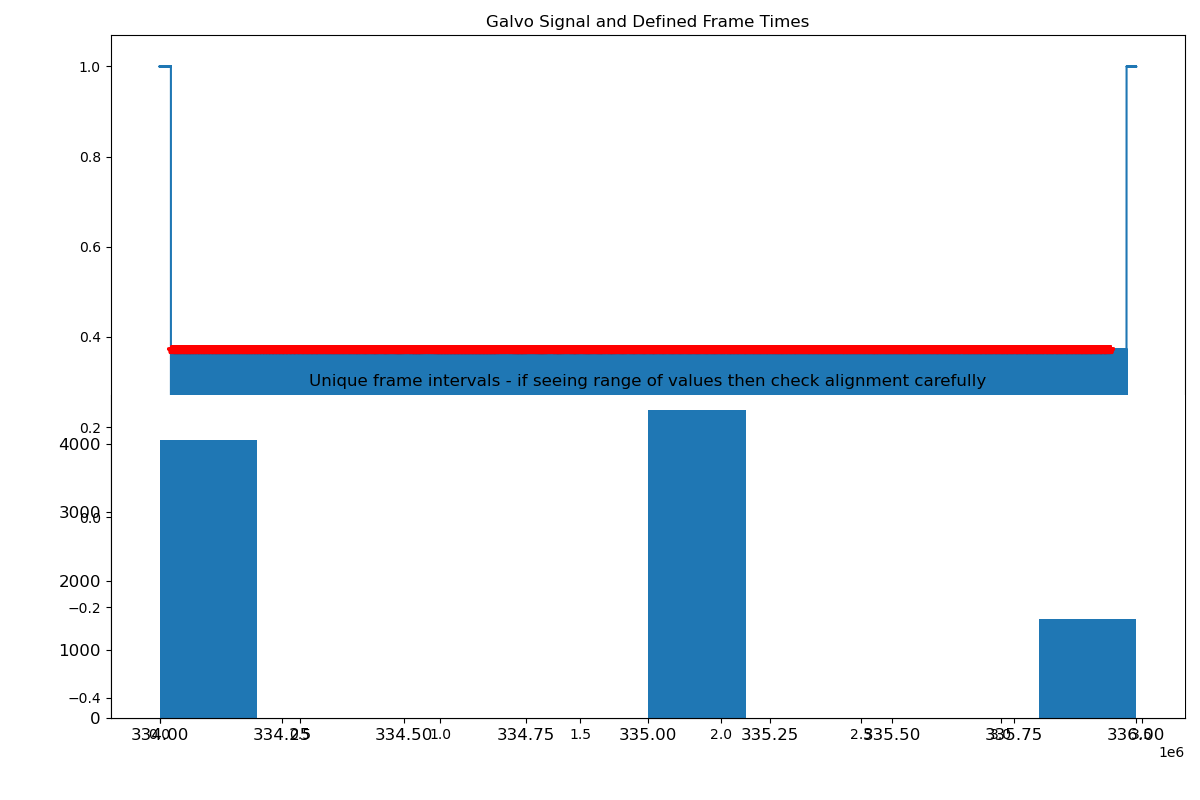

No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm: 5d7c8c7c6eae4bc1bffdaa2651ca0a7e
No such comm:

In [12]:
# Plot specific acquisitons in interactive plots to check the frame timings
idx = 1
acq = align_spirals.alignment_info[idx]
align_spirals.plot_frame_times(num=idx, galvo_signal=acq['galvo_signal_norm'],  frame_times=acq['frame_times'],plot_on=True)

#### **3.3 -** Get Spiral Locations and Timing

In [13]:
acquisition_data = align_spirals.get_spiral_locations(min_height=0.05)

for acq_data in acquisition_data:
    align_spirals.plot_spiral_detection(acq_data, save_dir=align_spirals.save_folder, show_plot=False)


Parsing TSeries-09232024-0912-844.xml
Top level keys: ['versionAttribute', 'dateAttribute', 'notesAttribute', 'SystemIDs', 'PVStateShard', 'Sequence']

Parsing TSeries-09232024-0912-844_Cycle00001_MarkPoints.xml
Top level keys: ['IterationsAttribute', 'IterationDelayAttribute', 'CalcFunctMapAttribute', 'PVMarkPointElement']

Parsing TSeries-09232024-0912-845.xml
Top level keys: ['versionAttribute', 'dateAttribute', 'notesAttribute', 'SystemIDs', 'PVStateShard', 'Sequence']

Parsing TSeries-09232024-0912-845_Cycle00001_MarkPoints.xml
Top level keys: ['IterationsAttribute', 'IterationDelayAttribute', 'CalcFunctMapAttribute', 'PVMarkPointElement']

Parsing TSeries-09232024-0912-846.xml
Top level keys: ['versionAttribute', 'dateAttribute', 'notesAttribute', 'SystemIDs', 'PVStateShard', 'Sequence']

Parsing TSeries-09232024-0912-846_Cycle00001_MarkPoints.xml
Top level keys: ['IterationsAttribute', 'IterationDelayAttribute', 'CalcFunctMapAttribute', 'PVMarkPointElement']

Parsing TSeries-09

c:\Users\RUNYAN1\OneDrive - University of Pittsburgh\Documents\GitHub\Runyan_lab_data_alignment_python\process_spirals.py:916: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\RUNYAN1\OneDrive - University of Pittsburgh\Documents\GitHub\Runyan_lab_data_alignment_python\process_spirals.py:921: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(spiral_plot_dir, filename))
c:\Users\RUNYAN1\OneDrive - University of Pittsburgh\Documents\GitHub\Runyan_lab_data_alignment_python\process_spirals.py:889: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15,10))


*Plot spiral locations for specific acquisitions in interactive plots*

c:\Users\RUNYAN1\AppData\Local\anaconda3\envs\neural_analysis\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


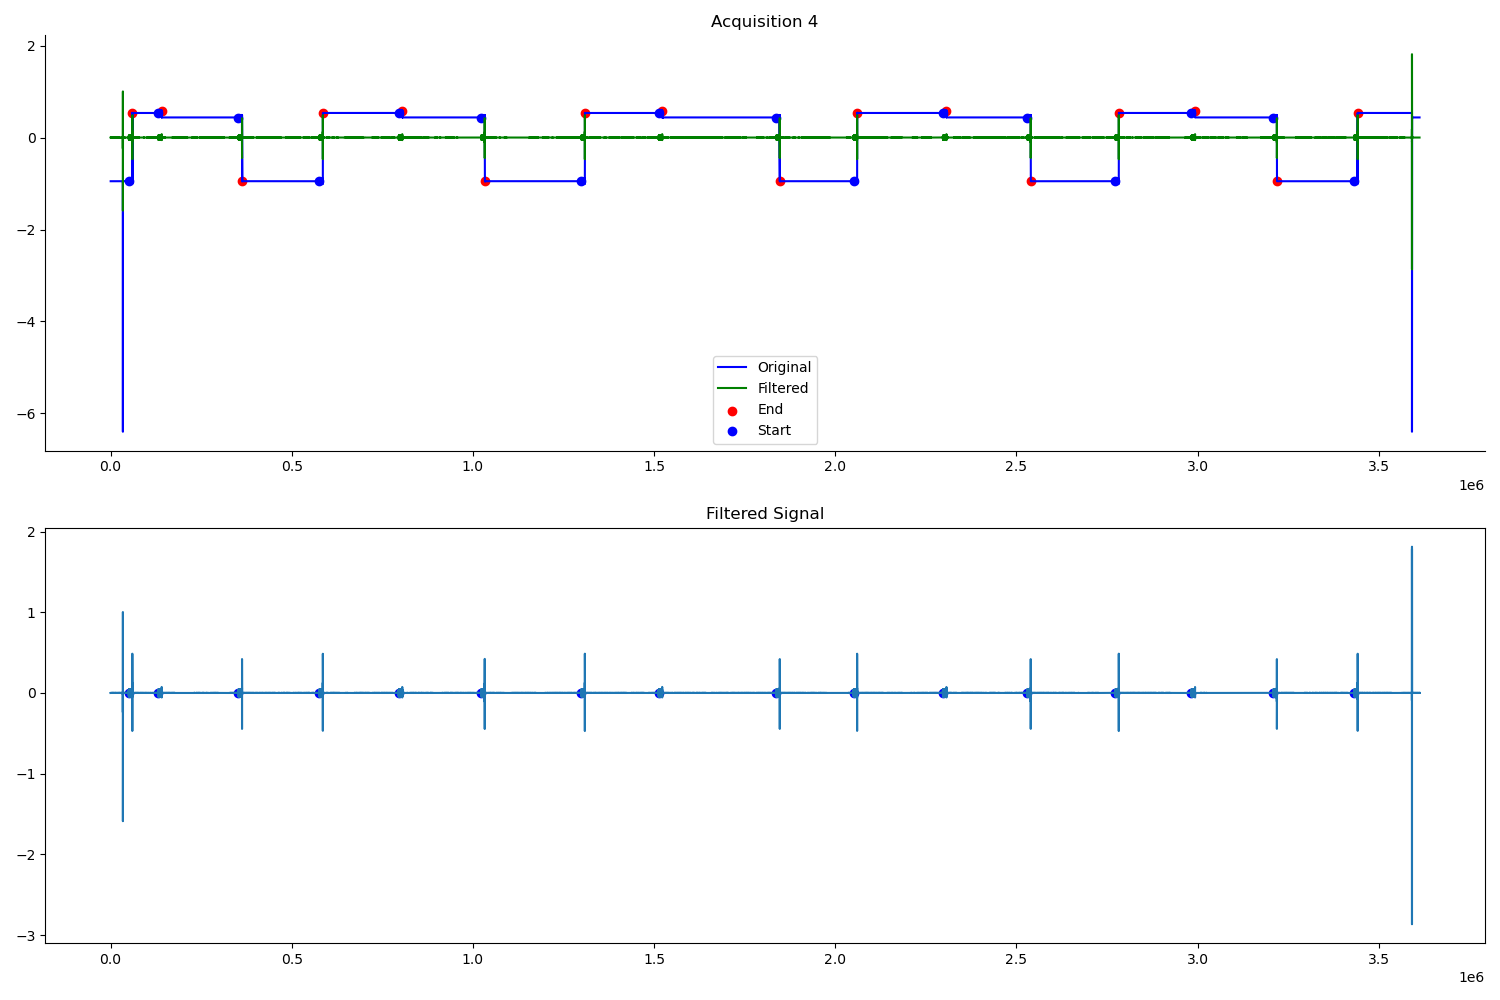

c:\Users\RUNYAN1\AppData\Local\anaconda3\envs\neural_analysis\lib\site-packages\ipympl\backend_nbagg.py:279: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.manager.handle_json(content)


In [14]:
# Look at individual acquisitions to inspect the accuracy of the spiral detections
align_spirals.plot_spiral_detection(acquisition_data[4])

#### **3.4 -** Make Trial Structure to review target response to photostimulation

In [261]:
# Set trial window parameters
pre_trial_window = 100
post_trial_window = 150

# Process targets and trials
align_spirals.process_targets_and_trials(
    pre_trial_window=pre_trial_window,
    post_trial_window=post_trial_window
)

#### **3.5 -** Create ROI Activity Plots of Potential Targets

In [264]:
def plot_ROI_traces_local(self, F_struct, pre_trial_window):
    for i in range(len(self.alignment_info[-1]['points'])):
        
        
        # Get ROIs for this target
        target_rois = self.trial_info['target_id'][i]
        dist_ids = np.array(self.trial_info['dist_id'][i])
        order = np.argsort(dist_ids)

        length = 5*(len(target_rois[order])) + 5

        plt.figure(figsize=(length, 5))
        
        for n, roi_idx in enumerate(target_rois[order]):
            
            plt.subplot(2, len(target_rois), n+1)
            
            # Plot all trials and mean if we have data for this ROI
            if roi_idx in F_struct[i]:
                # Get list of traces
                traces_list = F_struct[i][roi_idx]
                
                # Ensure all traces have the same length
                min_length = min(len(trace) for trace in traces_list)
                traces_array = np.array([trace[:min_length] for trace in traces_list])
                
                # Calculate the mean across trials
                mean_trace = np.mean(traces_array, axis=0)
                
                # Plot each trial
                # for trace in traces_array:
                #     plt.plot(trace.T, 'gray', alpha=0.3)  # Simply add .T here
                    
                # Plot the mean trace
                plt.plot(mean_trace, 'k', linewidth=2)
                plt.axvline(x=pre_trial_window,color='r',linestyle='--',linewidth=3)
                plt.title(f"ROI {roi_idx}")
                ax = plt.gca()
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)

     
        for n, roi_idx in enumerate(target_rois[order]):
            
            stat = self.stat 
            img = (ops['max_proj'] - ops['max_proj'].min()) / (ops['max_proj'].max() - ops['max_proj'].min())
            ops = self.ops
            plt.subplot(2,len(target_rois),(n+1)+len(target_rois))
            img = (ops['max_proj'] - ops['max_proj'].min()) / (ops['max_proj'].max() - ops['max_proj'].min())
            plt.imshow(img)

            plt.scatter(self.alignment_info[-1]['points'][i, 0], self.alignment_info[-1]['points'][i, 1], s=50, c='k', marker='o')
            plt.title('Target: ' + str(i+1) + ' ROI ' + str(roi_idx))
            plt.axis('off')
            self._plot_mask_boundaries(self.trial_info['target_id'][i][n], stat, color='r')

            

        # plt.subplot(2,len(target_rois), len(target_rois[order])+1)
        # for ii in range(len(self.trial_info['target_id'][i])):
        #     try:
        #         self._plot_mask_boundaries(self.trial_info['target_id'][i][ii], stat, color='r')
        #     except:
        #         continue

        if len(target_rois) ==0:
            ops = self.ops
            img = (ops['max_proj'] - ops['max_proj'].min()) / (ops['max_proj'].max() - ops['max_proj'].min())
            img = (ops['max_proj'] - ops['max_proj'].min()) / (ops['max_proj'].max() - ops['max_proj'].min())
            plt.imshow(img)
            plt.scatter(self.alignment_info[-1]['points'][i, 0], self.alignment_info[-1]['points'][i, 1], s=50, c='k', marker='o')
            plt.title('Location for target: ' + str(i) + ' [NO ROI FOUND]')

        roi_plot_dir = os.path.join(self.save_folder, 'roi plots')
        plt.tight_layout()
        plt.savefig(os.path.join(roi_plot_dir, f'{i+1} candidate rois neu correct.png'))
        plt.show()

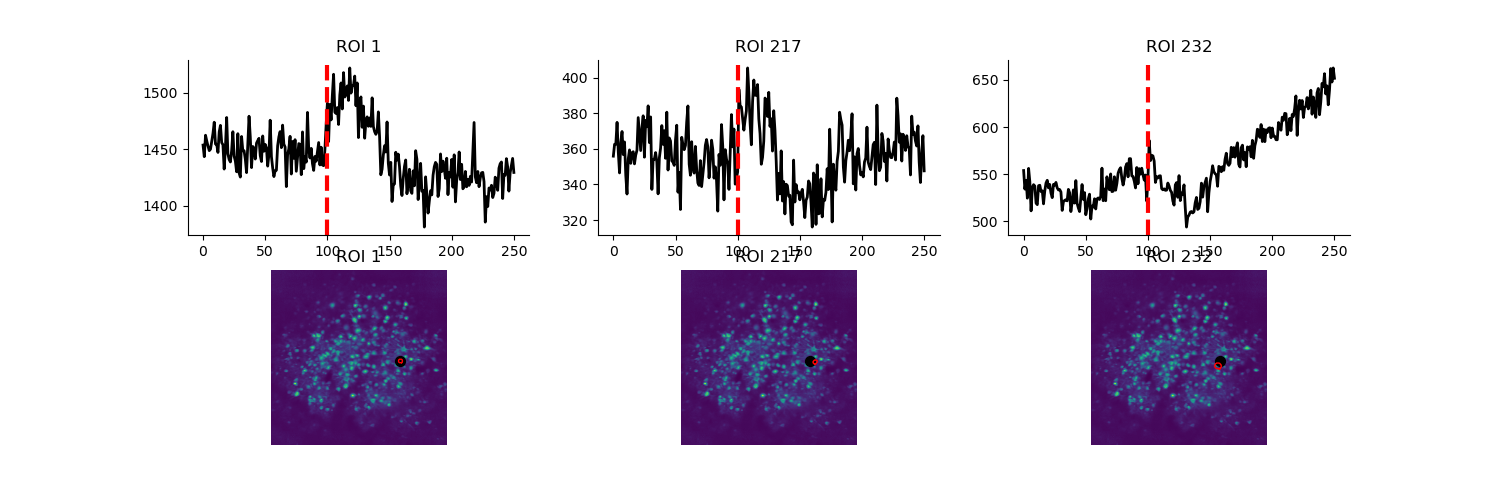

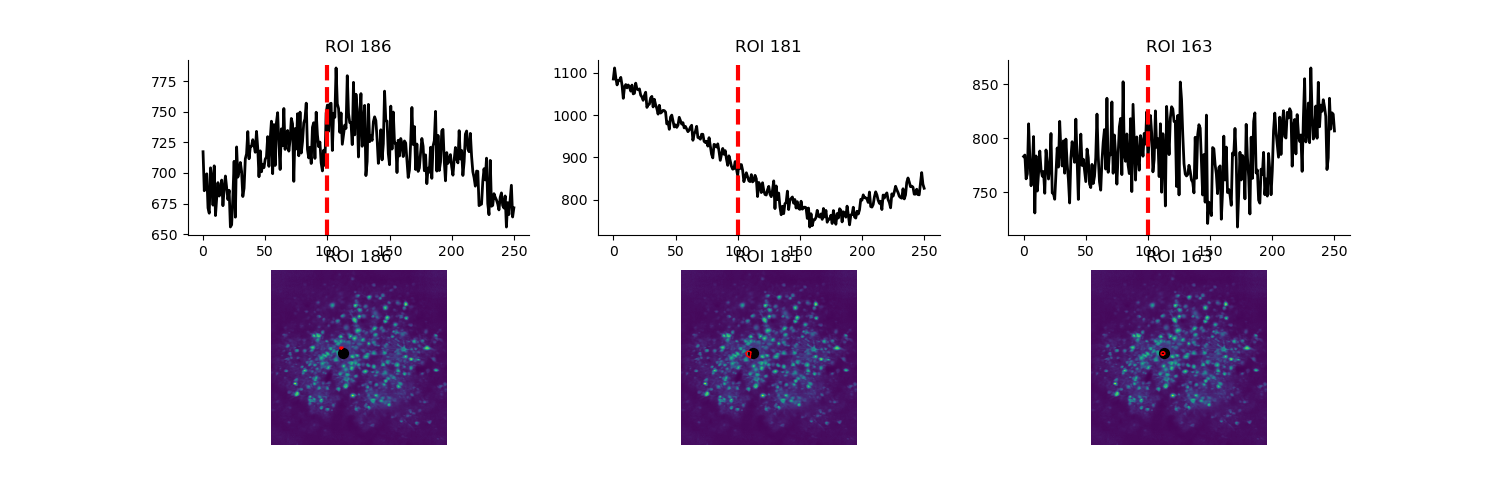

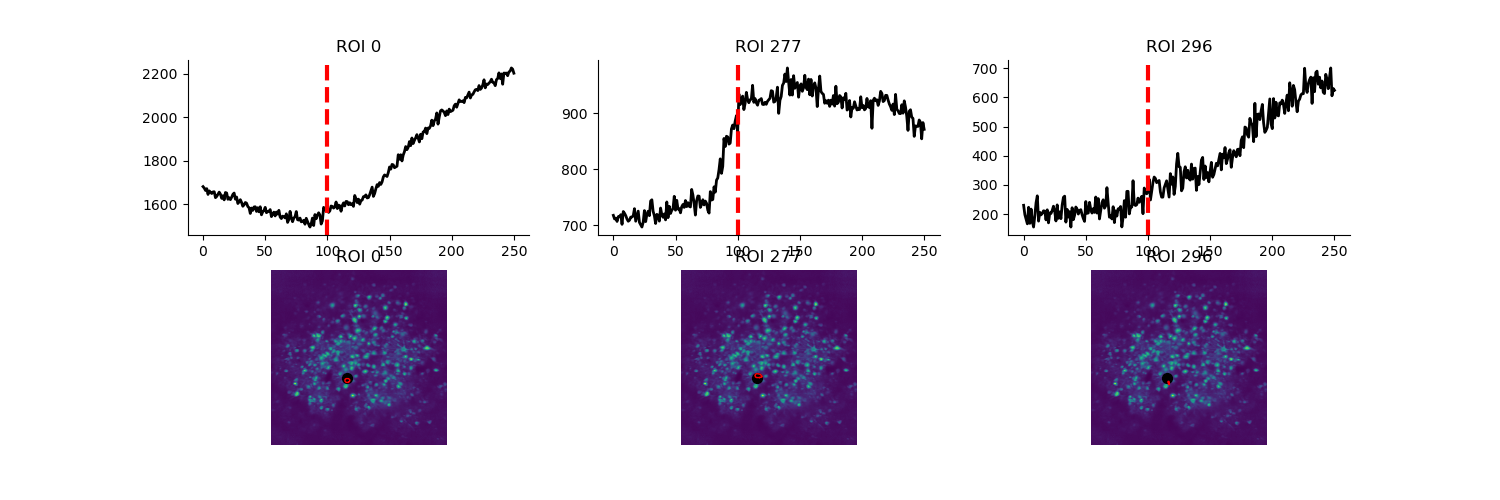

In [266]:
# Runs Automatically, use these plots to choose target ROIS
F_struct, roi_inds =  align_spirals.create_ROI_traces()

align_spirals.plot_ROI_traces(F_struct=F_struct,pre_trial_window=pre_trial_window) 

#plot_ROI_traces_local(align_spirals, F_struct=F_struct,pre_trial_window=pre_trial_window) 

*Choose ROIs for each target based on above plots*

In [267]:
## PICK WHICH ROI FITS THE TARGET
target_cells = np.ndarray(shape=[0,len(align_spirals.alignment_info[0]['points'])],dtype=int)
for targ in range(len(align_spirals.alignment_info[0]['points'])):
    ind = input('Input target cell ID for Target ' + str(targ+1))
    target_cells = np.append(target_cells,int(ind))
    
for targ in range(len(align_spirals.alignment_info[0]['points'])):
    print('Target ' + str(targ+1) + ' = ROI: ' + str(target_cells[targ]))


Target 1 = ROI: 1
Target 2 = ROI: 163
Target 3 = ROI: 0


#### **3.6 -** Save Spiral Alignment Info

In [268]:
# Save data for MATLAB
import scipy.io as sio

# save the suite2p and dff inds for each cell
act = os.path.join(align_spirals.base,'spikes', 'processed_activity_py.pkl')
with open (act, "rb") as file: 
    activity = pickle.load(file)
celi = activity['celi']

align_spirals.find_s2p_and_dff_indices(celi,target_cells)

# Create dictionary with all the relevant data
matlab_data = {
    'roi_inds': roi_inds,
    'trial_info': align_spirals.trial_info,
    'alignment_info': align_spirals.alignment_info,
}

# Save to .mat file
save_path = os.path.join(align_spirals.base, 'spirals_data.mat')
sio.savemat(save_path, matlab_data)

print(f"Data saved to: {save_path}")

Data saved to: \\runyan-fs-02.bns.pitt.edu\runyan4\Jordyn\ProcessedData\IA-6-3L\2024-09-24\spirals_data.mat


## **Section 4: Calculate Influence**

#### **4.1 -** Load class and relavent data

In [13]:
import importlib
code_directory = f'C:\\Users\\RUNYAN1\\OneDrive - University of Pittsburgh\\Documents\\GitHub\\Runyan_lab_data_alignment_python'
os.chdir(code_directory)
import pickle
import calculate_influence
from calculate_influence import CalculateInfluence
importlib.reload(calculate_influence)
inf = CalculateInfluence()

base = os.path.join(full_server, experimenter, 'ProcessedData', mouseID, date)

act = os.path.join(base,'spikes', 'processed_activity_py.pkl')
with open (act, "rb") as file: 
    activity = pickle.load(file)

t = os.path.join(base, 'trial_and_target_info.npz')
trial_info = np.load(t,allow_pickle=True)

deconv = activity['deconv']
dff = activity['dff']

offset_data = np.load(os.path.join(base,'offsetInfo.npz'),allow_pickle=True) 

spirals_data = scipy.io.loadmat(os.path.join(base,'spirals_data.mat'))

#microns_per_pixel = spirals_data['alignment_info'][0][13][0,0]['microns_per_pixel'][0][0]
microns_per_pixel = spirals_data['alignment_info'][0][0][0,0]['microns_per_pixel'][0][0]
del spirals_data

#### **4.2 -** Finalized trial frames, calculate influence & calculate distance between cells

In [270]:
# Remove stimulation trials with heavy motion 
trial_frames = trial_info['trial_frames']

trial_frames_final = inf.calculate_max_motion(dff,trial_frames,offset_data['distoff_um'])

# Calculate influence with updated trial structure
stim_id = trial_info['stim_id']
full_trials = trial_info['full_trials']

# Suite2p Data 
stat_file = os.path.join(base,'suite2p','plane0', 'stat.npy')       
stat = np.load(stat_file, allow_pickle=True)
#iscell = np.load(os.path.join(base,'suite2p','plane0', 'iscell.npy'))

Fall = scipy.io.loadmat(f"//runyan-fs-02.bns.pitt.edu/{server}/Jordyn/ProcessedData/{mouseID}/{date}/suite2p/plane0/Fall.mat")
iscell = Fall['iscell']


# Load indices for dff and s2p
with open(f'{base}\indices.pkl', 'rb') as file:
        indices = pickle.load(file)
active_inds = indices['dff_inds']['target_cell_dff']

non_inds = indices['dff_inds']['non_cell_dff']
red_inds = indices['dff_inds']['red_cell_dff']

cell_type_names = ['non', 'som'] # correspond to activity struct ordering

activity_struct = [dff[non_inds, :] , dff[red_inds]]
pre_trial_window = 100
post_trial_window = 150
influence_dff,structs = inf.inf_calculation(trial_frames_final, stim_id, activity_struct, pre_trial_window, post_trial_window, full_trials)


activity_struct = [deconv[non_inds, :] , deconv[red_inds]]
influence_deconv,structs = inf.inf_calculation(trial_frames_final, stim_id, activity_struct, pre_trial_window, post_trial_window, full_trials)

# Use those indices to populate cell locs structure
# cell_locs has the med pixels of each cell, cell_type is the cell_type at each index corresponding to cell_locs
# 0 = PYR, 1 = red

cell_locs, cell_type = inf.create_cell_locs_struct(base,stat,iscell)

# Calculate the distances between each cell groups (targets,PYR, red)
dist, dist_from_target, dist_from_target_red = inf.calculate_distances(active_inds, cell_locs, cell_type, trial_info['points'], microns_per_pixel, base)


In [ ]:
with open(f'{align_spirals.base}\indices.pkl', 'rb') as file:
    indices = pickle.load(file)

red_inds = indices['s2p_indices']['red_cell_inds']
non_inds = indices['s2p_indices']['non_cell_inds']

cell_locs = [] 
cell_type = []

for cell in range(len(stat)):
    if iscell[cell][0] == 1:
        cell_locs.append(stat[cell]['med'])
        if cell in red_inds:
            cell_type.append(1)
        elif cell in non_inds:
            cell_type.append(0)

#### **4.3 -** Save influence, distance, and updated imaging_py structure

In [271]:
def save_structures_local(base, distances,inf_data,activity):
    import hdf5storage

    name = os.path.join(base,'distances.pkl')
    with open(name,"wb") as file:
        pickle.dump(distances,file,)
    
    name = os.path.join(base,'distances.mat')
    hdf5storage.savemat(name,distances, format='7.3', oned_as='column',truncate_existing=True)

    name = os.path.join(base,'inf_data.pkl')
    with open(name,"wb") as file:
        pickle.dump(inf_data,file)

    name = os.path.join(base,'inf_data.mat')
    hdf5storage.savemat(name,inf_data, format='7.3', oned_as='column',truncate_existing=True)

    name = os.path.join(base,'activity.pkl')
    with open(name,"wb") as file:
        pickle.dump(activity,file)
    
    name = os.path.join(base,'activity.mat')
    hdf5storage.savemat(name,activity, format='7.3', oned_as='column',truncate_existing=True)



In [272]:
# package inf data into a save structure
distances = {
    'dist' : dist,
    'dist_from_target' : dist_from_target,
    'dist_from_target_red' : dist_from_target_red
}

influence_dff_str = {str(cell_type_names[key]) : value for key, value in influence_dff.items()}
influence_deconv_str = {str(cell_type_names[key]) : value for key, value in influence_dff.items()}
structs_str = {str(cell_type_names[key[0]])+ ' target: '+str(key[1]) : value for key, value in structs.items()}

influence = {
    'influence_dff' : influence_dff_str,
    'influence_deconv' :  influence_deconv_str
}

inf_data = { 
    "Influence" : influence,
    "dist_from_target" : dist_from_target,
    "noise_correlations" : np.NaN,
    "trial_activity" : structs_str,
    "significant_inf" : np.NaN,
    "trial_frames_final" : trial_frames_final,
    "distance" : distances
}

non_inds = indices['dff_inds']['non_cell_dff']
red_inds = indices['dff_inds']['red_cell_dff']

activity = {
    "dff_non" : dff[non_inds, :],
    "dff_red" : dff[red_inds,:],
    "deconv_non" : deconv[non_inds,:],
    "deconv_red" : deconv[red_inds]
}

#inf.save_structures(align_spirals.base, distances,inf_data,activity)
inf.save_structures(base, distances,inf_data,activity)

# ADD STIM ID VARIABLE TO IMAGING TRIAL STRUCTURE and Save Results
imaging_dict = align_spirals.add_stim_id_to_image_spk()


## **Extra testing and plotting**

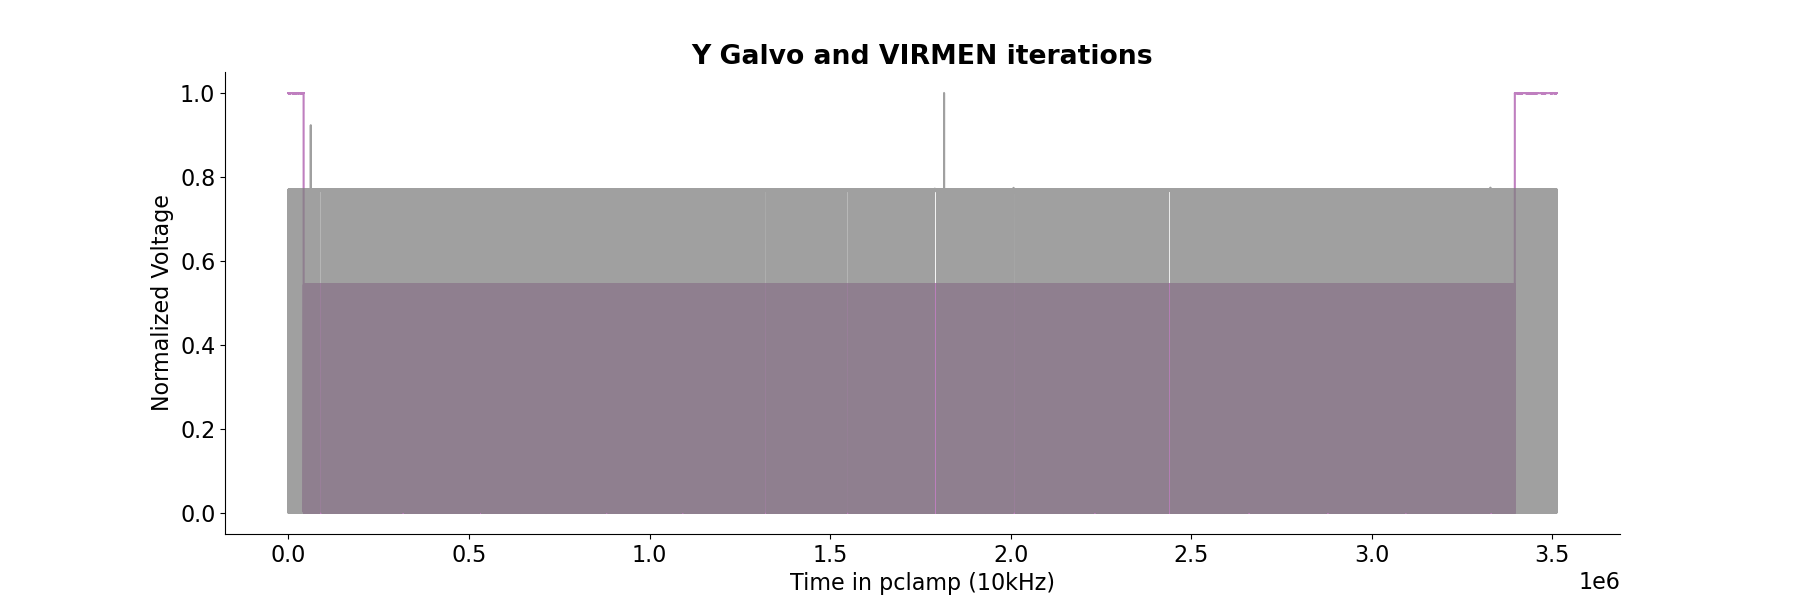

In [ ]:
## Visualization Plots

base = info['sync_base_path']
sync_files = [f for f in os.listdir(base) if f.endswith('.abf')]
path = os.path.join(base, sync_files[0])
sync_data = align_spirals._load_sync_data(path)

plt.figure(figsize=[18,6])
plt.rcParams.update({'font.size': 16})

galvo = range_normalize(sync_data[:,4])
virmen_its = range_normalize(sync_data[:,5])
plt.plot(galvo,color='purple',alpha=.5)
plt.plot(virmen_its,color='grey',alpha=.75)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Time in pclamp (10kHz)') 
plt.ylabel('Normalized Voltage')
plt.title('Y Galvo and VIRMEN iterations',fontweight='bold')
# plt.legend(['Imaging Y Galvo', 'VIRMEN Iterations' ])
plt.show()
